### Get feature importance

#### Feature selection

TO DO: READ ABOUT RECURSIVE FEATURE ELIMINTATION!!!!

Do recursive feature elimination first, then decision tree, get feature importance , set a threshold and choose the top 5 most important features


L1 (L2) regularization

PCA, then random forest classifier, get feature importance 

Autoencoder

#### Clustering

KMEANS
DBSCAN (sklearn)

## To do: clustering fuel only cars
1. T-SNE, read about it, do dimensionality reduction

## Pair wise clustering
1. Hybrid and electric
2. Hybrid and fuel

## Fuzzy logic
Can we calculate car membership?
Read on fuzzy logic 

## Consumer analysis with scraped data 
Predictor for time series sales data
Couple sales data with the co2 scores
Accumulated prediction for co2 impact 


In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from pathlib import Path

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics


from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))



In [2]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(Path("../data/predicted-data/","predicted_co2_rating.csv"))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26961 entries, 0 to 26960
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   vehicleclass_                  26961 non-null  object 
 1   make_                          26961 non-null  object 
 2   model.1_                       26961 non-null  object 
 3   model_year                     26961 non-null  int64  
 4   cylinders_                     26961 non-null  float64
 5   fuelconsumption_city(l/100km)  26961 non-null  float64
 6   fuelconsumption_hwy(l/100km)   26961 non-null  float64
 7   fuelconsumption_comb(l/100km)  26961 non-null  float64
 8   co2emissions_(g/km)            26961 non-null  int64  
 9   number_of_gears                26961 non-null  float64
 10  predicted_co2_rating           26961 non-null  int64  
 11  original_co2r                  7973 non-null   float64
 12  enginesize_(l)                 26961 non-null 

c:\anaconda3\envs\ml-project-env-10\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


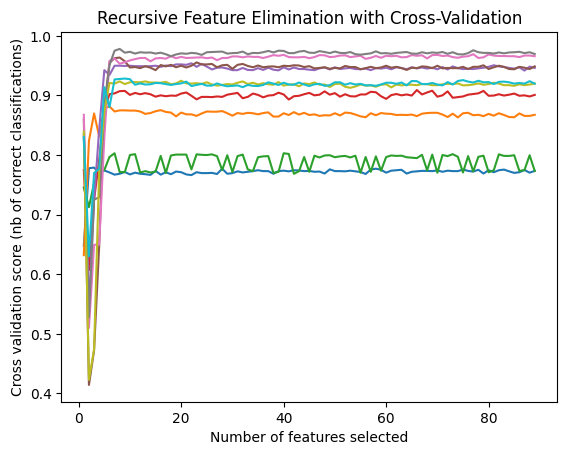

Selected features: Index(['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)',
       'fuelconsumption_hwy(l/100km)', 'co2emissions_(g/km)',
       'number_of_gears', 'fuelconsumption_comb(mpg)'],
      dtype='object')


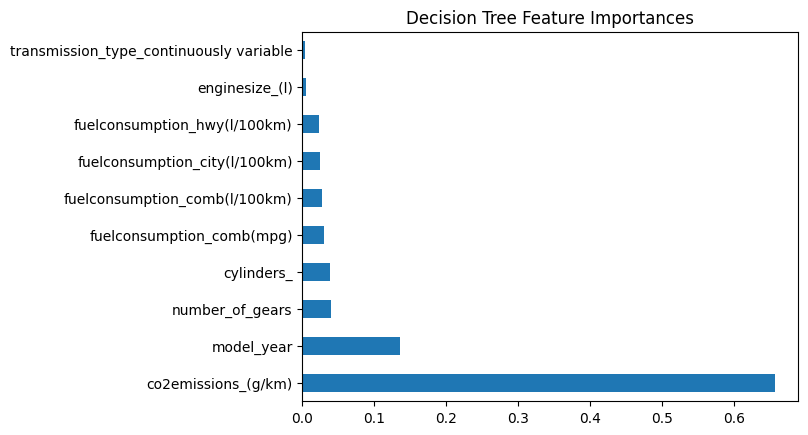

Top features: ['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 'co2emissions_(g/km)', 'number_of_gears', 'enginesize_(l)', 'fuelconsumption_comb(mpg)', 'transmission_type_continuously variable']


In [39]:
# Select the columns with numerical and categorical data
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# One-hot encode the categorical columns
df_cat = pd.get_dummies(df[['vehicleclass_','make_','vehicle_type','transmission_type']])
df_num = df[num_cols]

# Combine the numerical and one-hot encoded categorical dataframes
df_processed = pd.concat([df_num, df_cat], axis=1)

# Perform recursive feature elimination to select the most important features
X = df_processed.drop(["predicted_co2_rating", "original_co2r", "id"], axis=1)
y = df_processed["predicted_co2_rating"]

dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, cv=10)
rfecv.fit(X, y)

# Plot the number of features vs. cross-validation scores
plt.figure()
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Print the most important features
print("Selected features:", X.columns[rfecv.support_])

# Fit a decision tree and get feature importances
dt.fit(X, y)
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)

# Plot the feature importances
plt.figure()
plt.title('Decision Tree Feature Importances')
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Select the top 5 most important features
threshold = feat_importances.nlargest(10).min()
top_features = feat_importances[feat_importances >= threshold].index.tolist()
print("Top features:", top_features)


For n_clusters = 2 The inertia score is : 45401217.220729806 The average silhouette score is : 0.5415565311710775
For n_clusters = 3 The inertia score is : 23870111.175531086 The average silhouette score is : 0.5052963672903891
For n_clusters = 4 The inertia score is : 15791483.08415158 The average silhouette score is : 0.4757928462645982
For n_clusters = 5 The inertia score is : 11580156.423333671 The average silhouette score is : 0.4523833995310275
For n_clusters = 6 The inertia score is : 9009623.618580353 The average silhouette score is : 0.43466662413916163
For n_clusters = 7 The inertia score is : 7261475.911452834 The average silhouette score is : 0.43011090995121104
For n_clusters = 8 The inertia score is : 6144757.782599538 The average silhouette score is : 0.41002476021832895
For n_clusters = 9 The inertia score is : 5341834.449849843 The average silhouette score is : 0.39937001864175214
For n_clusters = 10 The inertia score is : 4718003.689106412 The average silhouette score

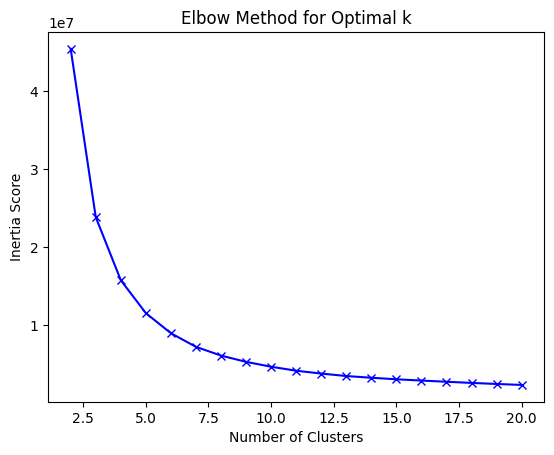

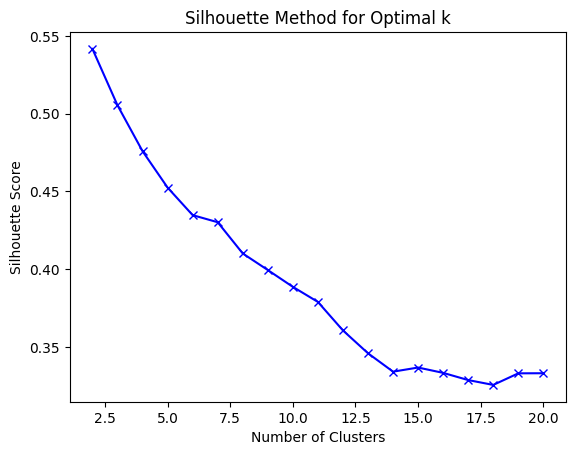

Number of clusters in DBSCAN: 197


In [40]:


# select the top 5 important features
# select only the top 5 important features
X = X[top_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])

# create a range of cluster numbers
range_n_clusters = range(2, 21)

# initialize lists to store the scores
silhouette_scores = []
inertia_scores = []

# loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    
    # initialize KMeans with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    
    # fit KMeans to the data
    kmeans.fit(X)
    
    # calculate the inertia score (within-cluster sum of squares)
    inertia_scores.append(kmeans.inertia_)
    
    # calculate the silhouette score
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # print the scores
    print("For n_clusters =", n_clusters,
          "The inertia score is :", kmeans.inertia_,
          "The average silhouette score is :", silhouette_avg)

# plot the elbow curve
plt.plot(range_n_clusters, inertia_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.title('Elbow Method for Optimal k')
plt.show()

# plot the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# initialize DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)

# fit DBSCAN to the data
dbscan.fit(X_scaled)

# print the number of clusters (unique labels) in DBSCAN
print("Number of clusters in DBSCAN:", len(np.unique(dbscan.labels_)))


In [41]:

def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    silhouette_scores = []
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters > 1:
                silhouette_score = metrics.silhouette_score(X, labels)
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters,
                      "and the average silhouette score is", silhouette_score)
                silhouette_scores.append(silhouette_score)
            else:
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters)
    # print the parameter combination with the highest silhouette score
    max_index = silhouette_scores.index(max(silhouette_scores))
    eps_index = max_index // len(min_samples_list)
    min_samples_index = max_index % len(min_samples_list)
    best_eps = eps_list[eps_index]
    best_min_samples = min_samples_list[min_samples_index]
    print("The best parameter combination is eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters > 1:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is :", silhouette_score)
    else:
        print("DBSCAN only found one cluster")


eps_list = [0.5, 1, 2, 4, 8, 16]
min_samples_list = [5, 10, 20, 50, 100, 200]

best_eps, best_min_samples = find_best_dbscan_params(X_scaled, eps_list, min_samples_list)
perform_best_dbscan(X_scaled, best_eps, best_min_samples)

For eps = 0.5 and min_samples = 5 the number of clusters is 189 and the average silhouette score is -0.15164098954563165
For eps = 0.5 and min_samples = 10 the number of clusters is 121 and the average silhouette score is -0.11844208264248796
For eps = 0.5 and min_samples = 20 the number of clusters is 70 and the average silhouette score is -0.12308218016599025
For eps = 0.5 and min_samples = 50 the number of clusters is 31 and the average silhouette score is -0.15814383742051122
For eps = 0.5 and min_samples = 100 the number of clusters is 19 and the average silhouette score is -0.21827881283367465
For eps = 0.5 and min_samples = 200 the number of clusters is 9 and the average silhouette score is -0.22967606312106198
For eps = 1 and min_samples = 5 the number of clusters is 30 and the average silhouette score is 0.004374748860503565
For eps = 1 and min_samples = 10 the number of clusters is 18 and the average silhouette score is 0.03239777280567371
For eps = 1 and min_samples = 20 the

In [ ]:
def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    max_silhouette_score = -1
    best_eps, best_min_samples = None, None
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters == 2:
                silhouette_score = metrics.silhouette_score(X, labels)
                if silhouette_score > max_silhouette_score:
                    max_silhouette_score = silhouette_score
                    best_eps, best_min_samples = eps, min_samples
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters,
                      "and the average silhouette score is", silhouette_score)
            else:
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters)
    # print the best hyperparameters
    print("The best hyperparameters for 2 clusters are: eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters == 2:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is:", silhouette_score)
    else:
        print("DBSCAN did not find 2 clusters")

# example usage

eps_list = [0.5, 4, 8, 16]
min_samples_list = [5, 10, 20, 50, 100, 200]

best_eps, best_min_samples = find_best_dbscan_params(X_scaled, eps_list, min_samples_list)
perform_best_dbscan(X_scaled, best_eps, best_min_samples)

In [42]:
n_clusters, labels = perform_dbscan(X_scaled, 4, 5)

In [43]:
original_data = scaler.inverse_transform(X_scaled)

pd.DataFrame(original_data, columns = top_features)

,model_year,cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),co2emissions_(g/km),number_of_gears,enginesize_(l),fuelconsumption_comb(mpg),transmission_type_continuously variable
0,2023.0,4.0,10.0,7.2,8.7,205.0,8.0,2.0,32.0,0.0
1,2023.0,4.0,10.5,7.7,9.2,217.0,8.0,2.0,31.0,0.0
2,2023.0,6.0,13.5,9.3,11.6,271.0,8.0,2.9,24.0,0.0
3,2023.0,4.0,10.3,8.1,9.3,218.0,8.0,2.0,30.0,0.0
4,2023.0,4.0,10.8,8.3,9.6,226.0,8.0,2.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...
26956,1999.0,5.0,13.4,9.4,11.6,267.0,4.0,2.3,24.0,0.0
26957,1999.0,5.0,13.4,9.4,11.6,267.0,5.0,2.3,24.0,0.0
26958,1999.0,5.0,13.1,9.1,11.3,260.0,4.0,2.4,25.0,0.0
26959,1999.0,5.0,12.7,9.0,11.0,253.0,5.0,2.4,26.0,0.0


In [44]:
df['cluster'] = labels

In [48]:
df['cluster'].value_counts()

0    25677
1     1284
Name: cluster, dtype: int64

In [49]:
df[df['cluster']==1]['predicted_co2_rating'].value_counts()

5     335
7     290
6     266
8     142
9     120
3      66
10     42
4      23
Name: predicted_co2_rating, dtype: int64

In [50]:
df[df['cluster']==0]['predicted_co2_rating'].value_counts()

5     6436
4     6162
3     5773
2     2268
6     2041
7     1457
1     1119
8      335
9       57
10      29
Name: predicted_co2_rating, dtype: int64

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot the data using t-SNE
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.show()

c:\anaconda3\envs\ml-project-env-10\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
